# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet101

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Setting up config Parameters

In [2]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 20,
    'PATIENCE': 5,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [3]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [5]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [6]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [7]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [8]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [9]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [11]:
model = resnet101(weights='IMAGENET1K_V2')

model.fc = nn.Linear(2048, 10)
model = model.to(config['DEVICE'])
model_name = "resnet101"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 240MB/s]


In [12]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

# Training

Training: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]


Epoch 1 | Train Loss: 0.48491886731409517 | Accuracy: 0.851831205752829 | Precision: 0.8562353707611922 | Recall: 0.851831205752829 | F1: 0.851987415090651


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.79it/s]


	Validation Loss: 0.04949109032618958 | Accuracy: 0.9866220735785953 | Precision: 0.9867407037517816 | Recall: 0.9866220735785953 | F1: 0.9866529774144054
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 2 | Train Loss: 0.0538350202381823 | Accuracy: 0.9847260159429176 | Precision: 0.9847482811880724 | Recall: 0.9847260159429176 | F1: 0.9847308632026897


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.15it/s]


	Validation Loss: 0.05818795236024323 | Accuracy: 0.9850613154960981 | Precision: 0.9853798024370566 | Recall: 0.9850613154960981 | F1: 0.9850301012282345


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 3 | Train Loss: 0.029588156279501277 | Accuracy: 0.9911923741568649 | Precision: 0.9912001016663007 | Recall: 0.9911923741568649 | F1: 0.9911953036353338


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.13it/s]


	Validation Loss: 0.02763953889247922 | Accuracy: 0.9928651059085841 | Precision: 0.992990390048656 | Recall: 0.9928651059085841 | F1: 0.9928640361818857
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 4 | Train Loss: 0.021540768242572034 | Accuracy: 0.9931434305145215 | Precision: 0.9931419940292027 | Recall: 0.9931434305145215 | F1: 0.9931414676473767


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


	Validation Loss: 0.027056320811438203 | Accuracy: 0.9933110367892977 | Precision: 0.9933182818575303 | Recall: 0.9933110367892977 | F1: 0.9932975015777661
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 5 | Train Loss: 0.01680144109784748 | Accuracy: 0.9951502313395395 | Precision: 0.9951536046699258 | Recall: 0.9951502313395395 | F1: 0.995151232952641


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.30it/s]


	Validation Loss: 0.018636341980645354 | Accuracy: 0.9944258639910813 | Precision: 0.9944966983210494 | Recall: 0.9944258639910813 | F1: 0.9944225315823769
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 6 | Train Loss: 0.010543071166790352 | Accuracy: 0.9970455432298344 | Precision: 0.9970464045099011 | Recall: 0.9970455432298344 | F1: 0.997045436731463


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


	Validation Loss: 0.013911980776112973 | Accuracy: 0.9964325529542921 | Precision: 0.9964634305369844 | Recall: 0.9964325529542921 | F1: 0.996435217885553
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 7 | Train Loss: 0.006101825183435191 | Accuracy: 0.9986621327833213 | Precision: 0.9986626424522295 | Recall: 0.9986621327833213 | F1: 0.9986622548022507


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


	Validation Loss: 0.03104505434963921 | Accuracy: 0.9919732441471572 | Precision: 0.9921960531562362 | Recall: 0.9919732441471572 | F1: 0.9919884277490316


Training: 100%|██████████| 281/281 [02:25<00:00,  1.94it/s]


Epoch 8 | Train Loss: 0.009601226149502233 | Accuracy: 0.9975472434360889 | Precision: 0.9975480121131628 | Recall: 0.9975472434360889 | F1: 0.9975472517203682


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.31it/s]


	Validation Loss: 0.03299952638015794 | Accuracy: 0.991304347826087 | Precision: 0.9917188350970543 | Recall: 0.991304347826087 | F1: 0.991275873642298


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 9 | Train Loss: 0.007283177429939011 | Accuracy: 0.9978817102402586 | Precision: 0.9978821736858493 | Recall: 0.9978817102402586 | F1: 0.9978816409105141


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


	Validation Loss: 0.016386282215637652 | Accuracy: 0.9946488294314382 | Precision: 0.9946733743777681 | Recall: 0.9946488294314382 | F1: 0.9946430994253154


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 10 | Train Loss: 0.0052103317003809844 | Accuracy: 0.9983834104465131 | Precision: 0.9983846927076548 | Recall: 0.9983834104465131 | F1: 0.9983836395113558


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


	Validation Loss: 0.008205798547171813 | Accuracy: 0.9977703455964325 | Precision: 0.9977758806904431 | Recall: 0.9977703455964325 | F1: 0.9977692303391963
Saving best model at epoch 10...


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 11 | Train Loss: 0.003479519818109991 | Accuracy: 0.9990523440548525 | Precision: 0.9990524837710025 | Recall: 0.9990523440548525 | F1: 0.9990523838617911


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.30it/s]


	Validation Loss: 0.012390832284926174 | Accuracy: 0.9971014492753624 | Precision: 0.9971150791009783 | Recall: 0.9971014492753624 | F1: 0.9970976494934927


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 12 | Train Loss: 0.0030762633044710565 | Accuracy: 0.9991638329895758 | Precision: 0.9991643625053707 | Recall: 0.9991638329895758 | F1: 0.9991639903272116


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


	Validation Loss: 0.010601992178712414 | Accuracy: 0.9977703455964325 | Precision: 0.9977813603408127 | Recall: 0.9977703455964325 | F1: 0.9977648844534304


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 13 | Train Loss: 0.002099160871516024 | Accuracy: 0.9994982997937455 | Precision: 0.9994984843563223 | Recall: 0.9994982997937455 | F1: 0.9994982530382861


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.33it/s]


	Validation Loss: 0.00844361656591375 | Accuracy: 0.9977703455964325 | Precision: 0.9977772007501104 | Recall: 0.9977703455964325 | F1: 0.9977687891243856


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 14 | Train Loss: 0.001212969748049542 | Accuracy: 0.9996097887284687 | Precision: 0.999609891375294 | Recall: 0.9996097887284687 | F1: 0.9996097808685188


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


	Validation Loss: 0.008700072700968365 | Accuracy: 0.9977703455964325 | Precision: 0.9977742605831909 | Recall: 0.9977703455964325 | F1: 0.9977697474491407


Training: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Epoch 15 | Train Loss: 0.0009023717416554886 | Accuracy: 0.9998885110652768 | Precision: 0.9998886422287294 | Recall: 0.9998885110652768 | F1: 0.9998885069585742


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.28it/s]


	Validation Loss: 0.008790949767732766 | Accuracy: 0.9979933110367893 | Precision: 0.9980024262088568 | Recall: 0.9979933110367893 | F1: 0.997992190420981
Early stopping at epoch 15
Training finished!


({'Loss': [0.48491886731409517,
   0.0538350202381823,
   0.029588156279501277,
   0.021540768242572034,
   0.01680144109784748,
   0.010543071166790352,
   0.006101825183435191,
   0.009601226149502233,
   0.007283177429939011,
   0.0052103317003809844,
   0.003479519818109991,
   0.0030762633044710565,
   0.002099160871516024,
   0.001212969748049542,
   0.0009023717416554886],
  'Accuracy': [0.851831205752829,
   0.9847260159429176,
   0.9911923741568649,
   0.9931434305145215,
   0.9951502313395395,
   0.9970455432298344,
   0.9986621327833213,
   0.9975472434360889,
   0.9978817102402586,
   0.9983834104465131,
   0.9990523440548525,
   0.9991638329895758,
   0.9994982997937455,
   0.9996097887284687,
   0.9998885110652768],
  'Precision': [0.8562353707611922,
   0.9847482811880724,
   0.9912001016663007,
   0.9931419940292027,
   0.9951536046699258,
   0.9970464045099011,
   0.9986626424522295,
   0.9975480121131628,
   0.9978821736858493,
   0.9983846927076548,
   0.999052483771

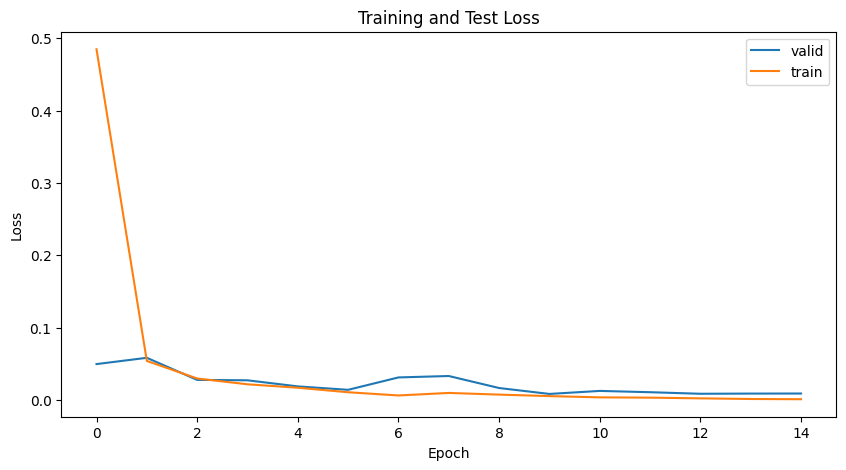

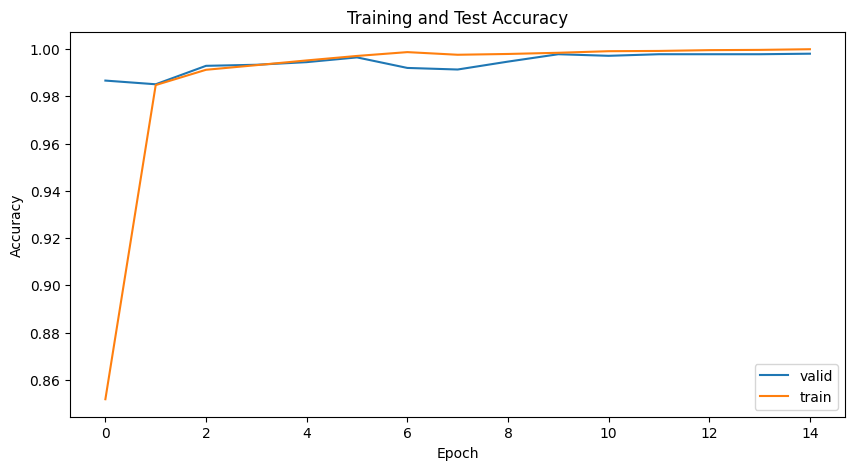

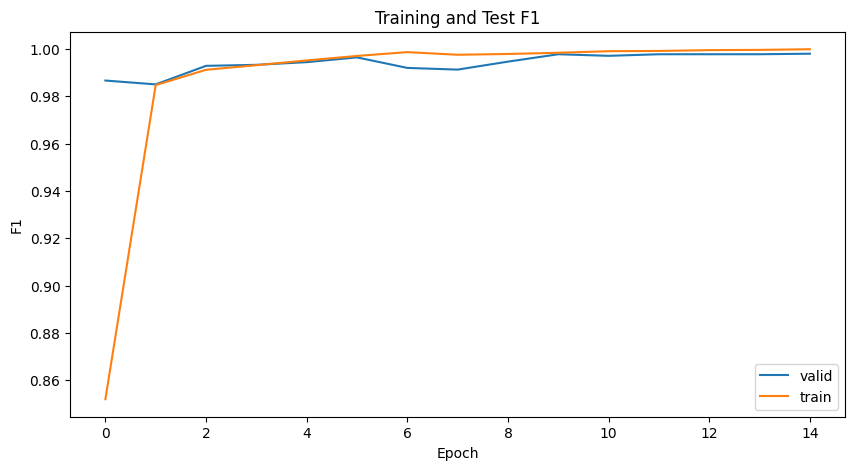

In [13]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [14]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [15]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [16]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [05:42<00:00,  3.64it/s]


In [17]:
df.to_csv(f'submission {model_name}.csv', index=False)